<a href="https://colab.research.google.com/github/secutron/TesTime/blob/main/test_controlnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

출처: https://github.com/tg-bomze/collection-of-notebooks/blob/master/Splice.ipynb

원본: [Splice](https://github.com/omerbt/Splice)

논문: [Splicing ViT Features for Semantic Appearance Transfer](https://arxiv.org/abs/2201.00424).

In [ ]:
import os
import shutil
from google.colab import files
from IPython.display import HTML
from pathlib import Path
from base64 import b64encode
import imghdr

!git clone https://github.com/omerbt/Splice.git
!mkdir /content/Splice/frames
os.chdir("/content/Splice")

DATAROOT = "./datasets/curr_pair"
path_dataroot = Path(DATAROOT)
if os.path.exists(path_dataroot):
  shutil.rmtree(path_dataroot)
path_A = Path(f"{DATAROOT}/A")
path_B = Path(f"{DATAROOT}/B")
path_A.mkdir(parents=True, exist_ok=True)
path_B.mkdir(parents=True, exist_ok=True)

Cloning into 'Splice'...
remote: Enumerating objects: 1376, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 1376 (delta 23), reused 50 (delta 23), pack-reused 1321
Receiving objects: 100% (1376/1376), 210.51 MiB | 7.62 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [ ]:
from IPython.display import display
from torchvision.transforms import Resize
from IPython.display import clear_output
from PIL import Image

def display_image(img):
  w, h = img.size
  if max(w, h) > 480:
    img = Resize(480, max_size=481)(img)
  display(img)


def process_upload(uploaded, data_path):
  if len(uploaded.keys()) > 1:
    clear_output(wait=True)
    for fn in uploaded.keys():
      os.remove(fn)
    print("Please choose 1 file!")
  else:
    fn = list(uploaded.keys())[0]
    if imghdr.what(fn) is None:
      clear_output(wait=True)
      print("Please upload a valid image file")
      os.remove(fn)
    else:
      dest_path = f"{data_path}/{fn}"
      shutil.move(fn, dest_path)
      clear_output(wait=True)
      print("Image successfully uploaded:")
      uploaded_image = Image.open(dest_path)
      display_image(uploaded_image)

### train.py 준비

In [ ]:
%%writefile /content/Splice/train.py
import torch
import gc
import numpy as np
import random
from data.Dataset import SingleImageDataset
from models.model import Model
from util.losses import LossG
from util.util import get_scheduler, get_optimizer, save_result
import yaml
from argparse import ArgumentParser
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train_model(dataroot, callback=None):
    with open("conf/default/config.yaml", "r") as f:
        config = yaml.safe_load(f)

    cfg = config

    if dataroot is not None:
        cfg['dataroot'] = dataroot

    # set seed
    seed = cfg['seed']
    if seed == -1:
        seed = np.random.randint(2 ** 32 - 1, dtype=np.int64)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
    print(f'running with seed: {seed}.')

    # create dataset, loader
    dataset = SingleImageDataset(cfg)

    # define model
    model = Model(cfg)

    # define loss function
    criterion = LossG(cfg)

    # define optimizer, scheduler
    optimizer = get_optimizer(cfg, model.netG.parameters())

    scheduler = get_scheduler(optimizer,
                              lr_policy=cfg['scheduler_policy'],
                              n_epochs=cfg['n_epochs'],
                              n_epochs_decay=cfg['scheduler_n_epochs_decay'],
                              lr_decay_iters=cfg['scheduler_lr_decay_iters'])

    with tqdm(range(1, cfg['n_epochs'] + 1)) as tepoch:
        for epoch in tepoch:
            inputs = dataset[0]
            for key in inputs:
                inputs[key] = inputs[key].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            losses = criterion(outputs, inputs)
            loss_G = losses['loss']
            log_data = losses
            log_data['epoch'] = epoch

            # update learning rate
            lr = optimizer.param_groups[0]['lr']
            log_data["lr"] = lr
            tepoch.set_description(f"Epoch {log_data['epoch']}")
            tepoch.set_postfix(loss=log_data["loss"].item(), lr=log_data["lr"])

            # log current generated entire image
            if epoch % cfg['log_images_freq'] == 0:
                img_A = dataset.get_A().to(device)
                with torch.no_grad():
                    output = model.netG(img_A)
                    torch.cuda.empty_cache()
                    gc.collect()
                save_result(output[0], cfg['dataroot'])
                if callback is not None:
                    callback(output[0])

            loss_G.backward()
            optimizer.step()
            scheduler.step()
            torch.cuda.empty_cache()
            gc.collect()


if __name__ == '__main__':
    parser = ArgumentParser()
    parser.add_argument("--dataroot", type=str)
    args = parser.parse_args()
    dataroot = args.dataroot

    train_model(dataroot)

Overwriting /content/Splice/train.py


### structure 준비

Image successfully uploaded:


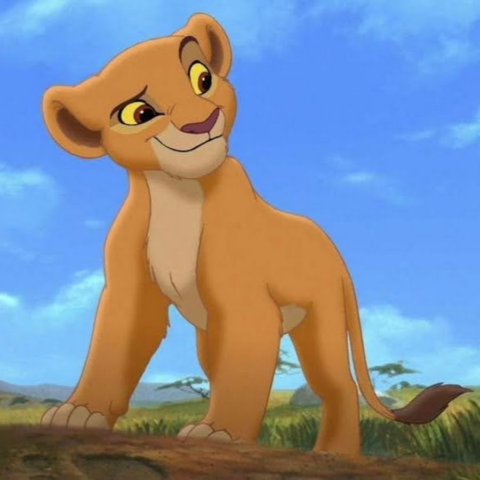

In [ ]:
shutil.rmtree(path_A)
path_A.mkdir(parents=True)
uploaded = files.upload()
process_upload(uploaded, f"{DATAROOT}/A")

### appearance 준비

Image successfully uploaded:


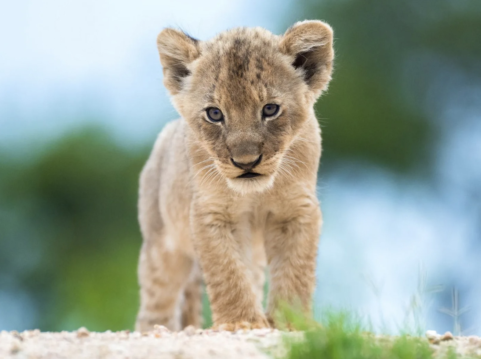

In [ ]:
shutil.rmtree(path_B)
path_B.mkdir(parents=True)
uploaded = files.upload()
process_upload(uploaded, f"{DATAROOT}/B")

### 변환

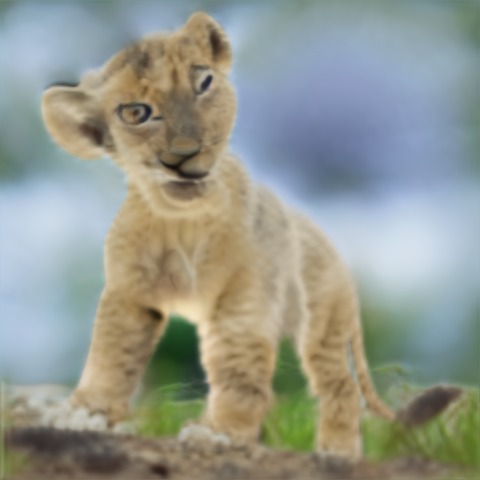

Epoch 7799:  78%|███████▊  | 7799/10000 [54:17<13:51,  2.65it/s, loss=0.077, lr=0.002]

In [ ]:
!rm -rf /content/Splice/frames/*
os.chdir("/content/Splice")
import cv2
import PIL
import glob
import numpy as np
from PIL import Image
from train import train_model
from torchvision.transforms import ToPILImage, Resize

def show_result(out_img):
  clear_output(wait=True)
  pilimg = ToPILImage()(out_img)
  # 230605 hkim
  img = np.array(pilimg)
  name = str(len(glob.glob('/content/Splice/frames/*.*g'))).zfill(7)
  #img.save(f'/content/Splice/frames/{name}.png')
  cv2.imwrite(f'/content/Splice/frames/{name}.png', img)
  display_image(pilimg)
  del img

train_model(DATAROOT, show_result)
print('Result: /content/Splice/datasets/curr_pair/out/output.png')

### 비디오

In [ ]:
print('Start generating')
!ffmpeg -y -r 60 -i /content/Splice/frames/%07d.png -c:v libx264 -vf fps=60 -pix_fmt yuv420p /content/result.mp4 -hide_banner -loglevel error
print('Video generated')
input_clip = open('/content/result.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(input_clip).decode()
HTML("""<video width=480 controls><source src="%s" type="video/mp4"></video>""" % data_url)